# Бейзлайн для распознавания автомобильных номеров. 

MADE with love :)

In [ ]:
# for colab
# ! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs' -O data.zip
# ! unzip -qq data.zip

#! pip install webp
#! pip install pillow

In [ ]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
torch.__version__, torch.cuda.is_available()

('1.4.0', True)

In [3]:
torch.cuda.get_device_name()

'Tesla T4'

### Сейчас будет много вспомогательных функций, которые можно промотать

Чтобы было наглядно и не приходилось лезть в модули, чтобы посмотреть, какая функция что делает, оставил для наглядности пока что все в ноутбуке. Можно аккуратно перенести в модули :)

In [5]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [6]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [7]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [8]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

### c) Обучаем модель для детекции

In [9]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

In [10]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [13]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

Class: plate, Confidence: 0.9985330104827881
Bounding box:


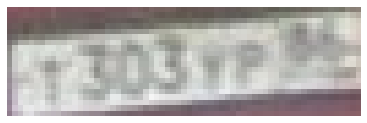

Rotated img:


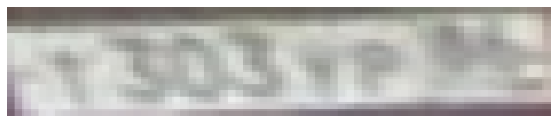

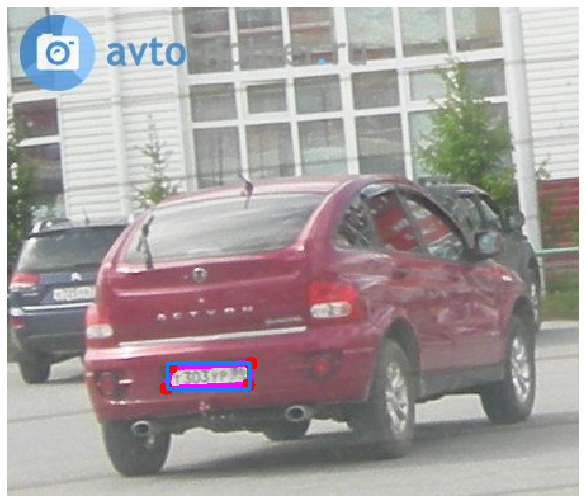

{'boxes': tensor([[126.8738, 281.5039, 191.6155, 301.5789]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9985], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

In [14]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [15]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:      
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

 19%|█▉        | 615/3188 [01:28<06:10,  6.94it/s]

simplify_contour didnt coverege


 61%|██████▏   | 1958/3188 [04:53<02:55,  7.03it/s]

simplify_contour didnt coverege


 74%|███████▍  | 2365/3188 [05:55<02:23,  5.72it/s]

simplify_contour didnt coverege


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [16]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [23]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet34')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=True
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

### c) Обучаем модель для распознавания текста номера

In [24]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [25]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [26]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/3016 [00:08<20:20,  2.46it/s]

Loss: 5.0988745


  1%|▏         | 40/3016 [00:16<22:09,  2.24it/s]

Loss: 3.4230867


  2%|▏         | 60/3016 [00:25<20:58,  2.35it/s]

Loss: 3.1871566


  3%|▎         | 80/3016 [00:33<20:19,  2.41it/s]

Loss: 3.0546250


  3%|▎         | 100/3016 [00:41<21:18,  2.28it/s]

Loss: 2.9267432


  4%|▍         | 120/3016 [00:49<20:10,  2.39it/s]

Loss: 2.7579863


  5%|▍         | 140/3016 [00:58<18:41,  2.56it/s]

Loss: 2.6491901


  5%|▌         | 160/3016 [01:07<19:52,  2.39it/s]

Loss: 2.6004100


  6%|▌         | 180/3016 [01:15<18:53,  2.50it/s]

Loss: 2.5172875


  7%|▋         | 200/3016 [01:23<20:31,  2.29it/s]

Loss: 2.3988802


  7%|▋         | 220/3016 [01:32<20:16,  2.30it/s]

Loss: 2.2846913


  8%|▊         | 240/3016 [01:40<18:23,  2.52it/s]

Loss: 2.1267052


  9%|▊         | 260/3016 [01:49<19:19,  2.38it/s]

Loss: 2.0636910


  9%|▉         | 280/3016 [01:57<19:12,  2.37it/s]

Loss: 1.9084205


 10%|▉         | 300/3016 [02:06<20:11,  2.24it/s]

Loss: 1.7391991


 11%|█         | 320/3016 [02:14<19:25,  2.31it/s]

Loss: 1.6387410


 11%|█▏        | 340/3016 [02:22<18:33,  2.40it/s]

Loss: 1.5612740


 12%|█▏        | 360/3016 [02:30<17:47,  2.49it/s]

Loss: 1.4392092


 13%|█▎        | 380/3016 [02:39<18:20,  2.40it/s]

Loss: 1.3817839


 13%|█▎        | 400/3016 [02:47<17:29,  2.49it/s]

Loss: 1.3373194


 14%|█▍        | 420/3016 [02:55<18:15,  2.37it/s]

Loss: 1.2726618


 15%|█▍        | 440/3016 [03:03<16:49,  2.55it/s]

Loss: 1.2792887


 15%|█▌        | 460/3016 [03:12<18:38,  2.28it/s]

Loss: 1.2873474


 16%|█▌        | 480/3016 [03:20<17:07,  2.47it/s]

Loss: 1.2318186


 17%|█▋        | 500/3016 [03:28<20:29,  2.05it/s]

Loss: 1.1721672


 17%|█▋        | 520/3016 [03:36<16:34,  2.51it/s]

Loss: 1.1502393


 18%|█▊        | 540/3016 [03:45<18:43,  2.20it/s]

Loss: 1.1147917


 19%|█▊        | 560/3016 [03:53<16:42,  2.45it/s]

Loss: 1.0120646


 19%|█▉        | 580/3016 [04:02<17:49,  2.28it/s]

Loss: 1.0277609


 20%|█▉        | 600/3016 [04:11<17:37,  2.28it/s]

Loss: 1.0001266


 21%|██        | 620/3016 [04:19<16:58,  2.35it/s]

Loss: 0.9803715


 21%|██        | 640/3016 [04:27<15:48,  2.51it/s]

Loss: 0.9234059


 22%|██▏       | 660/3016 [04:35<16:36,  2.36it/s]

Loss: 0.9058204


 23%|██▎       | 680/3016 [04:44<16:59,  2.29it/s]

Loss: 0.8391641


 23%|██▎       | 700/3016 [04:53<15:43,  2.45it/s]

Loss: 0.7819048


 24%|██▍       | 720/3016 [05:01<15:55,  2.40it/s]

Loss: 0.7761997


 25%|██▍       | 740/3016 [05:09<15:00,  2.53it/s]

Loss: 0.7301706


 25%|██▌       | 760/3016 [05:17<14:39,  2.56it/s]

Loss: 0.6702489


 26%|██▌       | 780/3016 [05:26<15:07,  2.46it/s]

Loss: 0.7122119


 27%|██▋       | 800/3016 [05:34<15:09,  2.44it/s]

Loss: 0.6445361


 27%|██▋       | 820/3016 [05:43<15:49,  2.31it/s]

Loss: 0.5934117


 28%|██▊       | 840/3016 [05:51<14:17,  2.54it/s]

Loss: 0.5775771


 29%|██▊       | 860/3016 [06:00<14:59,  2.40it/s]

Loss: 0.4922710


 29%|██▉       | 880/3016 [06:08<15:53,  2.24it/s]

Loss: 0.4875647


 30%|██▉       | 900/3016 [06:17<15:07,  2.33it/s]

Loss: 0.5026205


 31%|███       | 920/3016 [06:24<14:30,  2.41it/s]

Loss: 0.4610733


 31%|███       | 940/3016 [06:33<14:02,  2.46it/s]

Loss: 0.4177113


 32%|███▏      | 960/3016 [06:41<14:26,  2.37it/s]

Loss: 0.4279195


 32%|███▏      | 980/3016 [06:49<12:43,  2.67it/s]

Loss: 0.3636207


 33%|███▎      | 1000/3016 [06:58<14:48,  2.27it/s]

Loss: 0.3506113


 34%|███▍      | 1020/3016 [07:06<12:56,  2.57it/s]

Loss: 0.4061223


 34%|███▍      | 1040/3016 [07:14<14:11,  2.32it/s]

Loss: 0.3469489


 35%|███▌      | 1060/3016 [07:22<12:45,  2.56it/s]

Loss: 0.3203144


 36%|███▌      | 1080/3016 [07:31<15:32,  2.08it/s]

Loss: 0.3085229


 36%|███▋      | 1100/3016 [07:40<13:16,  2.41it/s]

Loss: 0.2974832


 37%|███▋      | 1120/3016 [07:48<12:28,  2.53it/s]

Loss: 0.2970891


 38%|███▊      | 1140/3016 [07:56<13:11,  2.37it/s]

Loss: 0.3147736


 38%|███▊      | 1160/3016 [08:04<12:36,  2.45it/s]

Loss: 0.2999061


 39%|███▉      | 1180/3016 [08:13<12:56,  2.36it/s]

Loss: 0.2727775


 40%|███▉      | 1200/3016 [08:21<14:20,  2.11it/s]

Loss: 0.2837522


 40%|████      | 1220/3016 [08:29<11:22,  2.63it/s]

Loss: 0.2215589


 41%|████      | 1240/3016 [08:38<12:44,  2.32it/s]

Loss: 0.2596205


 42%|████▏     | 1260/3016 [08:47<12:19,  2.37it/s]

Loss: 0.2484831


 42%|████▏     | 1280/3016 [08:55<11:42,  2.47it/s]

Loss: 0.2096160


 43%|████▎     | 1300/3016 [09:03<12:05,  2.37it/s]

Loss: 0.2442572


 44%|████▍     | 1320/3016 [09:11<11:06,  2.55it/s]

Loss: 0.2817032


 44%|████▍     | 1340/3016 [09:19<11:16,  2.48it/s]

Loss: 0.2316743


 45%|████▌     | 1360/3016 [09:28<11:35,  2.38it/s]

Loss: 0.2274352


 46%|████▌     | 1380/3016 [09:36<11:53,  2.29it/s]

Loss: 0.2697628


 46%|████▋     | 1400/3016 [09:45<11:37,  2.32it/s]

Loss: 0.2142296


 47%|████▋     | 1420/3016 [09:53<10:59,  2.42it/s]

Loss: 0.2151342


 48%|████▊     | 1440/3016 [10:01<10:35,  2.48it/s]

Loss: 0.1929423


 48%|████▊     | 1460/3016 [10:09<10:14,  2.53it/s]

Loss: 0.2067398


 49%|████▉     | 1480/3016 [10:18<10:39,  2.40it/s]

Loss: 0.2009389


 50%|████▉     | 1500/3016 [10:26<10:31,  2.40it/s]

Loss: 0.2208508


 50%|█████     | 1520/3016 [10:35<10:07,  2.46it/s]

Loss: 0.1937950


 51%|█████     | 1540/3016 [10:43<10:09,  2.42it/s]

Loss: 0.2246711


 52%|█████▏    | 1560/3016 [10:52<10:19,  2.35it/s]

Loss: 0.2502438


 52%|█████▏    | 1580/3016 [11:00<09:36,  2.49it/s]

Loss: 0.1892440


 53%|█████▎    | 1600/3016 [11:08<09:48,  2.40it/s]

Loss: 0.2073796


 54%|█████▎    | 1620/3016 [11:17<10:07,  2.30it/s]

Loss: 0.1445725


 54%|█████▍    | 1640/3016 [11:25<09:40,  2.37it/s]

Loss: 0.2591659


 55%|█████▌    | 1660/3016 [11:34<09:48,  2.30it/s]

Loss: 0.1916729


 56%|█████▌    | 1680/3016 [11:42<08:53,  2.50it/s]

Loss: 0.2148092


 56%|█████▋    | 1700/3016 [11:50<09:23,  2.34it/s]

Loss: 0.2365925


 57%|█████▋    | 1720/3016 [11:59<09:17,  2.32it/s]

Loss: 0.2318550


 58%|█████▊    | 1740/3016 [12:07<07:23,  2.88it/s]

Loss: 0.2101462


 58%|█████▊    | 1760/3016 [12:15<08:22,  2.50it/s]

Loss: 0.2376817


 59%|█████▉    | 1780/3016 [12:24<07:53,  2.61it/s]

Loss: 0.2312062


 60%|█████▉    | 1800/3016 [12:32<08:52,  2.28it/s]

Loss: 0.1744850


 60%|██████    | 1820/3016 [12:41<08:36,  2.31it/s]

Loss: 0.2153775


 61%|██████    | 1840/3016 [12:49<08:35,  2.28it/s]

Loss: 0.1915344
Epoch    92: reducing learning rate of group 0 to 1.5000e-04.


 62%|██████▏   | 1860/3016 [12:58<07:57,  2.42it/s]

Loss: 0.1862332


 62%|██████▏   | 1880/3016 [13:06<07:34,  2.50it/s]

Loss: 0.1909923


 63%|██████▎   | 1900/3016 [13:14<08:16,  2.25it/s]

Loss: 0.1477935


 64%|██████▎   | 1920/3016 [13:22<06:43,  2.72it/s]

Loss: 0.1742063


 64%|██████▍   | 1940/3016 [13:31<07:54,  2.27it/s]

Loss: 0.1498438


 65%|██████▍   | 1960/3016 [13:39<07:44,  2.27it/s]

Loss: 0.1407120


 66%|██████▌   | 1980/3016 [13:48<07:01,  2.46it/s]

Loss: 0.1600012


 66%|██████▋   | 2000/3016 [13:56<07:15,  2.33it/s]

Loss: 0.1334573


 67%|██████▋   | 2020/3016 [14:04<06:51,  2.42it/s]

Loss: 0.1618041


 68%|██████▊   | 2040/3016 [14:13<06:34,  2.47it/s]

Loss: 0.1519173


 68%|██████▊   | 2060/3016 [14:21<06:34,  2.42it/s]

Loss: 0.1792900


 69%|██████▉   | 2080/3016 [14:30<06:31,  2.39it/s]

Loss: 0.1511500


 70%|██████▉   | 2100/3016 [14:39<06:40,  2.29it/s]

Loss: 0.1625167


 70%|███████   | 2120/3016 [14:47<05:47,  2.58it/s]

Loss: 0.1604462


 71%|███████   | 2140/3016 [14:55<05:58,  2.45it/s]

Loss: 0.1689525


 72%|███████▏  | 2160/3016 [15:03<05:52,  2.43it/s]

Loss: 0.1240416


 72%|███████▏  | 2180/3016 [15:11<05:39,  2.47it/s]

Loss: 0.1678016


 73%|███████▎  | 2200/3016 [15:20<05:30,  2.47it/s]

Loss: 0.1610246


 74%|███████▎  | 2220/3016 [15:28<05:39,  2.34it/s]

Loss: 0.1620089


 74%|███████▍  | 2240/3016 [15:36<05:24,  2.39it/s]

Loss: 0.1256284


 75%|███████▍  | 2260/3016 [15:45<05:38,  2.23it/s]

Loss: 0.1273527


 76%|███████▌  | 2280/3016 [15:54<04:47,  2.56it/s]

Loss: 0.1524930


 76%|███████▋  | 2300/3016 [16:02<05:07,  2.33it/s]

Loss: 0.1298752


 77%|███████▋  | 2320/3016 [16:10<04:53,  2.37it/s]

Loss: 0.1674060


 78%|███████▊  | 2340/3016 [16:19<05:07,  2.20it/s]

Loss: 0.1399082


 78%|███████▊  | 2360/3016 [16:27<04:54,  2.23it/s]

Loss: 0.1095153


 79%|███████▉  | 2380/3016 [16:35<04:32,  2.33it/s]

Loss: 0.1413221


 80%|███████▉  | 2400/3016 [16:44<04:11,  2.45it/s]

Loss: 0.1089918


 80%|████████  | 2420/3016 [16:52<04:57,  2.00it/s]

Loss: 0.1712842


 81%|████████  | 2440/3016 [17:01<03:56,  2.43it/s]

Loss: 0.1602467


 82%|████████▏ | 2460/3016 [17:10<03:53,  2.38it/s]

Loss: 0.1318749


 82%|████████▏ | 2480/3016 [17:18<03:32,  2.53it/s]

Loss: 0.1175206


 83%|████████▎ | 2500/3016 [17:26<03:33,  2.42it/s]

Loss: 0.1823028


 84%|████████▎ | 2520/3016 [17:34<03:25,  2.42it/s]

Loss: 0.1321448


 84%|████████▍ | 2540/3016 [17:43<03:18,  2.40it/s]

Loss: 0.1499701


 85%|████████▍ | 2560/3016 [17:52<03:07,  2.44it/s]

Loss: 0.1387272


 86%|████████▌ | 2580/3016 [18:00<02:56,  2.47it/s]

Loss: 0.1201748


 86%|████████▌ | 2600/3016 [18:08<03:03,  2.27it/s]

Loss: 0.1254662


 87%|████████▋ | 2620/3016 [18:17<03:03,  2.16it/s]

Loss: 0.1116132
Epoch   131: reducing learning rate of group 0 to 7.5000e-05.


 88%|████████▊ | 2640/3016 [18:25<02:32,  2.46it/s]

Loss: 0.1356629


 88%|████████▊ | 2660/3016 [18:33<02:28,  2.40it/s]

Loss: 0.1437086


 89%|████████▉ | 2680/3016 [18:41<02:16,  2.46it/s]

Loss: 0.1106565


 90%|████████▉ | 2700/3016 [18:50<02:09,  2.44it/s]

Loss: 0.1737180


 90%|█████████ | 2720/3016 [18:58<02:01,  2.44it/s]

Loss: 0.1785067


 91%|█████████ | 2740/3016 [19:06<01:59,  2.30it/s]

Loss: 0.1761346


 92%|█████████▏| 2760/3016 [19:15<01:44,  2.44it/s]

Loss: 0.1386610


 92%|█████████▏| 2780/3016 [19:23<01:32,  2.54it/s]

Loss: 0.1381352


 93%|█████████▎| 2800/3016 [19:31<01:26,  2.51it/s]

Loss: 0.1227936


 94%|█████████▎| 2820/3016 [19:39<01:24,  2.31it/s]

Loss: 0.1432923


 94%|█████████▍| 2840/3016 [19:48<01:13,  2.40it/s]

Loss: 0.1667476
Epoch   142: reducing learning rate of group 0 to 3.7500e-05.


 95%|█████████▍| 2860/3016 [19:56<01:00,  2.56it/s]

Loss: 0.1802388


 95%|█████████▌| 2880/3016 [20:04<00:57,  2.35it/s]

Loss: 0.1544271


 96%|█████████▌| 2900/3016 [20:12<00:49,  2.36it/s]

Loss: 0.1268053


 97%|█████████▋| 2920/3016 [20:20<00:39,  2.45it/s]

Loss: 0.1358657


 97%|█████████▋| 2940/3016 [20:29<00:29,  2.54it/s]

Loss: 0.1114188


 98%|█████████▊| 2960/3016 [20:37<00:24,  2.27it/s]

Loss: 0.1073264


 99%|█████████▉| 2980/3016 [20:46<00:14,  2.43it/s]

Loss: 0.1497151


 99%|█████████▉| 3000/3016 [20:54<00:06,  2.39it/s]

Loss: 0.1131662


  0%|          | 0/3016 [00:00<?, ?it/s]           

3015 0.6039862741471641


  1%|          | 20/3016 [00:08<20:20,  2.45it/s]

Loss: 0.1160325


  1%|▏         | 40/3016 [00:17<19:19,  2.57it/s]

Loss: 0.1002769


  2%|▏         | 60/3016 [00:25<19:49,  2.48it/s]

Loss: 0.1075285


  3%|▎         | 80/3016 [00:34<21:33,  2.27it/s]

Loss: 0.1029207


  3%|▎         | 100/3016 [00:42<18:54,  2.57it/s]

Loss: 0.1590597


  4%|▍         | 120/3016 [00:50<19:15,  2.51it/s]

Loss: 0.1324334


  5%|▍         | 140/3016 [00:59<20:20,  2.36it/s]

Loss: 0.1472604


  5%|▌         | 160/3016 [01:07<18:50,  2.53it/s]

Loss: 0.1239504


  6%|▌         | 180/3016 [01:15<19:06,  2.47it/s]

Loss: 0.1122147


  7%|▋         | 200/3016 [01:23<18:27,  2.54it/s]

Loss: 0.1199076


  7%|▋         | 220/3016 [01:32<19:05,  2.44it/s]

Loss: 0.1191788


  8%|▊         | 240/3016 [01:40<19:32,  2.37it/s]

Loss: 0.1022075


  9%|▊         | 260/3016 [01:49<18:50,  2.44it/s]

Loss: 0.1070341
Epoch   163: reducing learning rate of group 0 to 1.8750e-05.


  9%|▉         | 280/3016 [01:57<19:05,  2.39it/s]

Loss: 0.1027752


 10%|▉         | 300/3016 [02:05<20:08,  2.25it/s]

Loss: 0.1466887


 11%|█         | 320/3016 [02:13<19:18,  2.33it/s]

Loss: 0.1062335


 11%|█▏        | 340/3016 [02:22<18:16,  2.44it/s]

Loss: 0.1416937


 12%|█▏        | 360/3016 [02:30<17:24,  2.54it/s]

Loss: 0.1054315


 13%|█▎        | 380/3016 [02:38<17:24,  2.52it/s]

Loss: 0.1353300


 13%|█▎        | 400/3016 [02:46<18:26,  2.36it/s]

Loss: 0.0741073


 14%|█▍        | 420/3016 [02:55<18:29,  2.34it/s]

Loss: 0.1305965


 15%|█▍        | 440/3016 [03:04<18:27,  2.33it/s]

Loss: 0.1253432


 15%|█▌        | 460/3016 [03:12<18:34,  2.29it/s]

Loss: 0.1151686


 16%|█▌        | 480/3016 [03:20<18:23,  2.30it/s]

Loss: 0.0886391


 17%|█▋        | 500/3016 [03:29<18:06,  2.32it/s]

Loss: 0.0898415


 17%|█▋        | 520/3016 [03:37<16:23,  2.54it/s]

Loss: 0.1076516


 18%|█▊        | 540/3016 [03:45<18:20,  2.25it/s]

Loss: 0.1064287


 19%|█▊        | 560/3016 [03:53<15:45,  2.60it/s]

Loss: 0.1339653


 19%|█▉        | 580/3016 [04:01<15:47,  2.57it/s]

Loss: 0.1221012


 20%|█▉        | 600/3016 [04:09<16:51,  2.39it/s]

Loss: 0.0939836


 21%|██        | 620/3016 [04:18<18:31,  2.16it/s]

Loss: 0.1004288
Epoch   181: reducing learning rate of group 0 to 9.3750e-06.


 21%|██        | 640/3016 [04:27<19:36,  2.02it/s]

Loss: 0.0979146


 22%|██▏       | 660/3016 [04:35<15:43,  2.50it/s]

Loss: 0.1046435


 23%|██▎       | 680/3016 [04:43<16:38,  2.34it/s]

Loss: 0.1158278


 23%|██▎       | 700/3016 [04:52<16:51,  2.29it/s]

Loss: 0.0921541


 24%|██▍       | 720/3016 [05:00<15:47,  2.42it/s]

Loss: 0.1572326


 25%|██▍       | 740/3016 [05:08<16:11,  2.34it/s]

Loss: 0.1077279


 25%|██▌       | 760/3016 [05:16<15:39,  2.40it/s]

Loss: 0.1437486


 26%|██▌       | 780/3016 [05:25<16:10,  2.30it/s]

Loss: 0.0764995


 27%|██▋       | 800/3016 [05:34<15:04,  2.45it/s]

Loss: 0.1233982


 27%|██▋       | 820/3016 [05:42<17:35,  2.08it/s]

Loss: 0.1394506


 28%|██▊       | 840/3016 [05:51<15:58,  2.27it/s]

Loss: 0.1232843
Epoch   192: reducing learning rate of group 0 to 4.6875e-06.


 29%|██▊       | 860/3016 [05:59<14:46,  2.43it/s]

Loss: 0.1360670


 29%|██▉       | 880/3016 [06:08<14:41,  2.42it/s]

Loss: 0.1163423


 30%|██▉       | 900/3016 [06:16<14:21,  2.46it/s]

Loss: 0.1165465


 31%|███       | 920/3016 [06:24<15:20,  2.28it/s]

Loss: 0.1111856


 31%|███       | 940/3016 [06:33<14:52,  2.33it/s]

Loss: 0.1615116


 32%|███▏      | 960/3016 [06:41<15:15,  2.25it/s]

Loss: 0.0954186


 32%|███▏      | 980/3016 [06:50<13:47,  2.46it/s]

Loss: 0.0936503


 33%|███▎      | 1000/3016 [06:57<14:12,  2.37it/s]

Loss: 0.1170374


 34%|███▍      | 1020/3016 [07:06<14:26,  2.30it/s]

Loss: 0.1264714


 34%|███▍      | 1040/3016 [07:14<14:37,  2.25it/s]

Loss: 0.1378143


 35%|███▌      | 1060/3016 [07:22<13:18,  2.45it/s]

Loss: 0.1145002
Epoch   203: reducing learning rate of group 0 to 2.3437e-06.


 36%|███▌      | 1080/3016 [07:31<13:19,  2.42it/s]

Loss: 0.1071946


 36%|███▋      | 1100/3016 [07:39<13:58,  2.29it/s]

Loss: 0.1473010


 37%|███▋      | 1120/3016 [07:47<12:20,  2.56it/s]

Loss: 0.1019487


 38%|███▊      | 1140/3016 [07:56<13:07,  2.38it/s]

Loss: 0.1124069


 38%|███▊      | 1160/3016 [08:04<12:46,  2.42it/s]

Loss: 0.1200297


 39%|███▉      | 1180/3016 [08:13<13:12,  2.32it/s]

Loss: 0.1109747


 40%|███▉      | 1200/3016 [08:21<12:56,  2.34it/s]

Loss: 0.1567404


 40%|████      | 1220/3016 [08:29<12:14,  2.45it/s]

Loss: 0.1128725


 41%|████      | 1240/3016 [08:38<11:52,  2.49it/s]

Loss: 0.1331372


 42%|████▏     | 1260/3016 [08:46<12:13,  2.40it/s]

Loss: 0.0989058


 42%|████▏     | 1280/3016 [08:54<12:38,  2.29it/s]

Loss: 0.1621202
Epoch   214: reducing learning rate of group 0 to 1.1719e-06.


 43%|████▎     | 1300/3016 [09:03<11:58,  2.39it/s]

Loss: 0.1323859


 44%|████▍     | 1320/3016 [09:11<11:19,  2.50it/s]

Loss: 0.1394439


 44%|████▍     | 1340/3016 [09:19<10:43,  2.60it/s]

Loss: 0.1364363


 45%|████▌     | 1360/3016 [09:27<11:31,  2.40it/s]

Loss: 0.1421224


 46%|████▌     | 1380/3016 [09:36<11:53,  2.29it/s]

Loss: 0.0959130


 46%|████▋     | 1400/3016 [09:44<10:43,  2.51it/s]

Loss: 0.1084870


 47%|████▋     | 1420/3016 [09:53<12:01,  2.21it/s]

Loss: 0.1135160


 48%|████▊     | 1440/3016 [10:01<11:56,  2.20it/s]

Loss: 0.1215901


 48%|████▊     | 1460/3016 [10:10<10:40,  2.43it/s]

Loss: 0.1054897


 49%|████▉     | 1480/3016 [10:18<10:01,  2.55it/s]

Loss: 0.1094893


 50%|████▉     | 1500/3016 [10:26<09:28,  2.66it/s]

Loss: 0.1118939
Epoch   225: reducing learning rate of group 0 to 5.8594e-07.


 50%|█████     | 1520/3016 [10:34<09:49,  2.54it/s]

Loss: 0.1150303


 51%|█████     | 1540/3016 [10:43<11:31,  2.14it/s]

Loss: 0.1241480


 52%|█████▏    | 1560/3016 [10:51<09:37,  2.52it/s]

Loss: 0.1119928


 52%|█████▏    | 1580/3016 [10:59<08:56,  2.67it/s]

Loss: 0.1050573


 53%|█████▎    | 1600/3016 [11:08<10:41,  2.21it/s]

Loss: 0.0875126


 54%|█████▎    | 1620/3016 [11:16<10:09,  2.29it/s]

Loss: 0.1318905


 54%|█████▍    | 1640/3016 [11:25<10:15,  2.23it/s]

Loss: 0.1120920


 55%|█████▌    | 1660/3016 [11:33<09:46,  2.31it/s]

Loss: 0.1216853


 56%|█████▌    | 1680/3016 [11:41<08:47,  2.53it/s]

Loss: 0.1059335


 56%|█████▋    | 1700/3016 [11:50<10:19,  2.12it/s]

Loss: 0.1278160


 57%|█████▋    | 1720/3016 [11:59<09:10,  2.35it/s]

Loss: 0.1281511
Epoch   236: reducing learning rate of group 0 to 2.9297e-07.


 58%|█████▊    | 1740/3016 [12:08<08:54,  2.39it/s]

Loss: 0.1147382


 58%|█████▊    | 1760/3016 [12:16<09:15,  2.26it/s]

Loss: 0.1218722


 59%|█████▉    | 1780/3016 [12:25<08:44,  2.36it/s]

Loss: 0.0982224


 60%|█████▉    | 1800/3016 [12:33<08:07,  2.49it/s]

Loss: 0.1213665


 60%|██████    | 1820/3016 [12:42<08:57,  2.23it/s]

Loss: 0.1302029


 61%|██████    | 1840/3016 [12:50<08:26,  2.32it/s]

Loss: 0.1479581


 62%|██████▏   | 1860/3016 [12:58<08:04,  2.38it/s]

Loss: 0.1002797


 62%|██████▏   | 1880/3016 [13:07<07:53,  2.40it/s]

Loss: 0.1247888


 63%|██████▎   | 1900/3016 [13:15<07:25,  2.50it/s]

Loss: 0.1041922


 64%|██████▎   | 1920/3016 [13:23<06:43,  2.71it/s]

Loss: 0.1168375


 64%|██████▍   | 1940/3016 [13:31<07:48,  2.30it/s]

Loss: 0.1534298
Epoch   247: reducing learning rate of group 0 to 1.4648e-07.


 65%|██████▍   | 1960/3016 [13:40<07:27,  2.36it/s]

Loss: 0.1233697


 66%|██████▌   | 1980/3016 [13:48<06:27,  2.67it/s]

Loss: 0.1308568


 66%|██████▋   | 2000/3016 [13:57<07:31,  2.25it/s]

Loss: 0.1131815


 67%|██████▋   | 2020/3016 [14:05<06:24,  2.59it/s]

Loss: 0.1279349


 68%|██████▊   | 2040/3016 [14:13<06:35,  2.47it/s]

Loss: 0.1187844


 68%|██████▊   | 2060/3016 [14:22<06:30,  2.45it/s]

Loss: 0.1088637


 69%|██████▉   | 2080/3016 [14:30<05:56,  2.63it/s]

Loss: 0.1351063


 70%|██████▉   | 2100/3016 [14:38<05:48,  2.63it/s]

Loss: 0.1059809


 70%|███████   | 2120/3016 [14:46<06:30,  2.30it/s]

Loss: 0.1314923


 71%|███████   | 2140/3016 [14:55<06:06,  2.39it/s]

Loss: 0.1279128


 72%|███████▏  | 2160/3016 [15:04<06:10,  2.31it/s]

Loss: 0.1081624
Epoch   258: reducing learning rate of group 0 to 7.3242e-08.


 72%|███████▏  | 2180/3016 [15:12<05:48,  2.40it/s]

Loss: 0.1677044


 73%|███████▎  | 2200/3016 [15:21<05:52,  2.31it/s]

Loss: 0.0875304


 74%|███████▎  | 2220/3016 [15:29<05:19,  2.49it/s]

Loss: 0.1083743


 74%|███████▍  | 2240/3016 [15:37<04:48,  2.69it/s]

Loss: 0.1014191


 75%|███████▍  | 2260/3016 [15:45<04:48,  2.62it/s]

Loss: 0.1147422


 76%|███████▌  | 2280/3016 [15:54<05:01,  2.44it/s]

Loss: 0.0912905


 76%|███████▋  | 2300/3016 [16:02<04:41,  2.54it/s]

Loss: 0.1272565


 77%|███████▋  | 2320/3016 [16:11<05:07,  2.26it/s]

Loss: 0.1056676


 78%|███████▊  | 2340/3016 [16:19<05:03,  2.23it/s]

Loss: 0.1419211


 78%|███████▊  | 2360/3016 [16:27<04:45,  2.30it/s]

Loss: 0.1205195


 79%|███████▉  | 2380/3016 [16:35<04:28,  2.37it/s]

Loss: 0.0941568
Epoch   269: reducing learning rate of group 0 to 3.6621e-08.


 80%|███████▉  | 2400/3016 [16:44<04:43,  2.17it/s]

Loss: 0.1215162


 80%|████████  | 2420/3016 [16:53<04:18,  2.30it/s]

Loss: 0.1200931


 81%|████████  | 2440/3016 [17:01<04:08,  2.31it/s]

Loss: 0.1284294


 82%|████████▏ | 2460/3016 [17:10<03:39,  2.53it/s]

Loss: 0.1312713


 82%|████████▏ | 2480/3016 [17:18<03:37,  2.46it/s]

Loss: 0.1059788


 83%|████████▎ | 2500/3016 [17:27<03:56,  2.18it/s]

Loss: 0.1093271


 84%|████████▎ | 2520/3016 [17:35<03:35,  2.30it/s]

Loss: 0.0775041


 84%|████████▍ | 2540/3016 [17:44<03:09,  2.51it/s]

Loss: 0.1224758


 85%|████████▍ | 2560/3016 [17:52<02:52,  2.64it/s]

Loss: 0.1118525


 86%|████████▌ | 2580/3016 [18:00<02:42,  2.69it/s]

Loss: 0.1241503


 86%|████████▌ | 2600/3016 [18:07<02:32,  2.73it/s]

Loss: 0.0983489
Epoch   280: reducing learning rate of group 0 to 1.8311e-08.


 87%|████████▋ | 2620/3016 [18:16<02:48,  2.35it/s]

Loss: 0.0911590


 88%|████████▊ | 2640/3016 [18:24<02:33,  2.45it/s]

Loss: 0.0999405


 88%|████████▊ | 2660/3016 [18:32<02:17,  2.59it/s]

Loss: 0.0945664


 89%|████████▉ | 2680/3016 [18:41<02:10,  2.58it/s]

Loss: 0.1173234


 90%|████████▉ | 2700/3016 [18:49<02:06,  2.49it/s]

Loss: 0.0873758


 90%|█████████ | 2720/3016 [18:57<01:49,  2.71it/s]

Loss: 0.1471974


 91%|█████████ | 2740/3016 [19:06<01:50,  2.49it/s]

Loss: 0.0906215


 92%|█████████▏| 2760/3016 [19:14<01:48,  2.35it/s]

Loss: 0.1153278


 92%|█████████▏| 2780/3016 [19:22<01:41,  2.32it/s]

Loss: 0.0797217


 93%|█████████▎| 2800/3016 [19:30<01:32,  2.34it/s]

Loss: 0.1070951


 94%|█████████▎| 2820/3016 [19:38<01:24,  2.33it/s]

Loss: 0.1212265


 94%|█████████▍| 2840/3016 [19:46<01:09,  2.54it/s]

Loss: 0.0830006


 95%|█████████▍| 2860/3016 [19:55<01:03,  2.44it/s]

Loss: 0.0974261


 95%|█████████▌| 2880/3016 [20:03<00:55,  2.46it/s]

Loss: 0.1136439


 96%|█████████▌| 2900/3016 [20:12<00:43,  2.65it/s]

Loss: 0.1472337


 97%|█████████▋| 2920/3016 [20:20<00:41,  2.33it/s]

Loss: 0.1107167


 97%|█████████▋| 2940/3016 [20:28<00:31,  2.44it/s]

Loss: 0.1044401


 98%|█████████▊| 2960/3016 [20:37<00:22,  2.51it/s]

Loss: 0.1179235


 99%|█████████▉| 2980/3016 [20:45<00:15,  2.38it/s]

Loss: 0.0868390


 99%|█████████▉| 3000/3016 [20:53<00:06,  2.63it/s]

Loss: 0.1277512


3015 0.11638673538013561


In [27]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

### d) Наконец, делаем предсказания

In [28]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission2.csv', index=False)

Как-то так :)